In [1]:
from numba import jit, cuda 
from scipy.signal import convolve2d
from scipy.integrate import ode
import numpy as np
from PIL import Image as img

In [6]:
# hàm trạng thái
def hamTrangThai(t, x, uB1, uB2, A1, A2, n, m):
    x = x.reshape(n, m)
    dx = uB1 + convolve2d(hamDauRa(x), A1, 'same') + uB2 + tichChapBacHai(hamDauRa(x), A2) + I
    #dx = convolve2d(u, B1, 'same') + convolve2d(hamDauRa(x), A1, 'same') + tichChapBacHai(u, B2) + tichChapBacHai(hamDauRa(x), A2) + I
    return dx.reshape(n*m)

# Hàm tính tích chập bậc hai chạy trên GPU thông qua thư viện Numba (vì chạy trên CPU quá chậm)
@jit(target_backend='cuda')
#def tichChapBacHai_numba(y, A):
def tichChapBacHai(y, A):
    m, n = y.shape
    ketQua = np.zeros(y.shape) # tạo ma trận 0 có kích thước bằng ma trận y để lưu kết quả
    for i in range(m):
        for j in range(n):
            # xét từng điểm trên ma trận y kích thước m, n
            for k in range(3):#0.. 2
                for l in range(3):#0.. 2
                    # xét từng ma trận trong bộ A21 đến A29 (trong code là A[0] đến A[8])
                    x = k*3+l # ma trận A[x] đang được xét
                    for r in range(-1,2):#-1.. 1
                        for s in range(-1,2):#-1.. 1
                            # nhân từng số của ma trận láng giềng y(i,j;r,s) với ma trận A[x]
                            if(0<=i+r<m and 0<=j+s<n and 0<=i+1-k<m and 0<=j+1-l<n):
                                ketQua[i][j]+=A[x][r][s]*y[i+1-k][j+1-l]*y[i+r][j+s]
    return ketQua

# hàm đầu ra
def hamDauRa(x):
    return 0.5 * (np.abs(x + 1) - np.abs(x - 1))

# Tạo ma trận đối xứng từ 5 trọng số (hàm này chỉ dành riêng cho ma trận đối xứng 3x3)
def taoMaTranDoiXung(arr1):#giả sử cho mảng [1,2,3,4,5]
    arr2 = arr1[-2::-1].copy()#tạo mảng phụ [4,3,2,1]
    #arr2[0], arr2[2] = arr2[2], arr2[0]#nếu có thì sẽ đối xứng theo đường chéo phụ, nếu không thì sẽ là đối xứng tâm
    #print(f'arr1 = {arr1}, arr2 = {arr2}')
    return np.append(arr1,arr2).reshape(h,h)#kết hợp hai mảng rồi chuyển về dạng ma trận 3x3

# Trong công thức biến đổi từ mạng Nơ-ron phẩn hồi sang truyền thẳng, trọng số và đầu vào , đầu ra phải được nhân với nhau theo thứ tự nhất định (xem lại công thứ)
# hàm sau đây sẽ sắp xếp lại các số trọng bộ ma trận trọng số để tương ứng với công thức.
def taoMaTranDoiXungPerceptron(arr1):
    return taoMaTranDoiXung(np.array([arr1[2],arr1[1],arr1[3],arr1[0],arr1[4]]))

# Hàm tạo số ngẫu nhiên từ -9.99 đến 9.99
def ngauNhien():
    return np.random.randint(-999,1000)/100.

# Hàm tính sai số
def saiSo(d,y):
    return np.sum(0.5*(d-y)**2)

def loadSample(path):
    return np.array(img.open(path).convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0

# Bán kính lân cận của nơ ron tế bào
r = 1

# kích thước của ma trận điều khiển và ma trận phản hồi (hai ma trận này luôn vuông)
h = 2*r + 1 # h = 3

class CNN:

    slts = 101 # số lượng trọng số trong quần thể

    # Quần thể trọng số (gồm 11 số)
    #quanThe = np.array([ngauNhien() for i in range(slts)])
    quanThe = np.array([0.,0.,0.,0.,2.]*10+[0.,0.,0.,0.,0.]*10+[1.])
    #quanThe = np.array([4.]*101)

    # ma trận ảnh đầu vào u
    # u = np.array(img.open('images/u1.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0
    u = [
        loadSample('images/u1_1.png'),
        loadSample('images/u1_2.png'),
        loadSample('images/u1_3.png'),
        loadSample('images/u1_4.png'),
        loadSample('images/u1_5.png'),
    ]

    # kích thước ma trận đầu vào, ma trận đầu ra và ma trận trạng thái
    m, n = u[0].shape
    print(m,n)

    # ma trận đầu ra mong muốn d
    # d = np.array(img.open('images/d1.png').convert('RGB'), dtype=float)[:,:,0]/255.0*2.0-1.0
    d = [
        loadSample('images/d1_1.png'),
        loadSample('images/d1_2.png'),
        loadSample('images/d1_3.png'),
        loadSample('images/d1_4.png'),
        loadSample('images/d1_5.png'),
    ]

    # hai giá trị ban đầu cho ptvp gồm x0 = [ma trận toàn số 0] với t0 = 0.0 và t1 để tính đầu ra x1 (t1 != t0)
    x0, t0, t1 = [i.copy() for i in u], 0.0, 0.2

    # ma trận đầu ra y (y được tính theo x)
    y = [hamDauRa(i) for i in x0]

    # Tốc độ học của thuật toán
    alpha = 0.01

    E0 = 2.0*len(u)

cnn = CNN()

# In ra bộ ma trận trọng số:
def print_maTranTrongSo():
    print(f'A1 = {taoMaTranDoiXung(cnn.quanThe[:5])}')
    for i in range(9):
        print(f'A2{i+1} = {taoMaTranDoiXung(cnn.quanThe[i*5+5:i*5+10])}')
    print(f'B1 = {taoMaTranDoiXung(cnn.quanThe[50:55])}')
    for i in range(9):
        print(f'B2{i+1} = {taoMaTranDoiXung(cnn.quanThe[i*5+55:i*5+60])}')
    print(f'I = {cnn.quanThe[100]}')

# tạo thêm biên gồm toàn số 0 bao quanh ma trận a để tránh tràn biên
def them_bien(a):
    b = np.zeros(shape=[a.shape[0]+2,a.shape[1]+2])
    for i in range(1,a.shape[0]+1):
        for j in range(1,a.shape[1]+1):
            b[i][j] = a[i-1][j-1]
    return b

# Hàm để lấy trọng số từ file trongSoBac2ToiUu rồi lưu vào cnn.quanThe
def getQuanThe(i):# lấy bộ trọng số thứ i
    A1 = np.loadtxt(f'TrongSoBac2ToiUu/TrongSoBac2_{i}/A1.txt')
    A2 = []
    for j in range(1,10):
        A2.append(np.loadtxt(f'TrongSoBac2ToiUu/TrongSoBac2_{i}/A2{j}.txt'))
    B1 = np.loadtxt(f'TrongSoBac2ToiUu/TrongSoBac2_{i}/B1.txt')
    B2 = []
    for j in range(1,10):
        B2.append(np.loadtxt(f'TrongSoBac2ToiUu/TrongSoBac2_{i}/B2{j}.txt'))
    I = np.loadtxt(f'TrongSoBac2ToiUu/TrongSoBac2_{i}/I.txt')
    qt = [A1[0][0],A1[0][1],A1[0][2],A1[1][0],A1[1][1]]
    for A2x in A2:
        qt += [A2x[0][0],A2x[0][1],A2x[0][2],A2x[1][0],A2x[1][1]]
    qt += [B1[0][0],B1[0][1],B1[0][2],B1[1][0],B1[1][1]]
    for B2x in B2:
        qt += [B2x[0][0],B2x[0][1],B2x[0][2],B2x[1][0],B2x[1][1]]
    qt += [I]
    cnn.quanThe = np.array(qt)

# tính x, tính y, tính wij và cập trọng số
def capNhatTrongSo():
    for i in range(1,cnn.m):
        for j in range(1,cnn.n):
            ptvp.set_initial_value(cnn.x0.flatten(), 0.)
            A1 = taoMaTranDoiXungPerceptron(cnn.quanThe[:5])
            A2 = []
            for c in range(1,10):
                A2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j:5*j+5]))
            B1 = taoMaTranDoiXungPerceptron(cnn.quanThe[50:55])
            B2 = []
            for c in range(1,10):
                B2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j+50:5*j+55]))
            I = cnn.quanThe[100]
            uB1 = convolve2d(cnn.u, B1, 'same')
            uB2 = tichChapBacHai(cnn.u, B2)
            ptvp.set_f_params(uB1, uB2, A1, A2, cnn.n, cnn.m)            
            x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
            cnn.y = hamDauRa(x)
            cnn.y = np.sign(cnn.y)
            y = them_bien(cnn.y) # thêm biên 0 cho y để tránh tràn biên
            u = them_bien(cnn.u) # thêm biên 0 cho u để tránh tràn biên  

            Ys = [
                y[i-1][j] + y[i+1][j], 
                y[i][j-1] + y[i][j+1],
                y[i-1][j-1] + y[i+1][j+1],
                y[i-1][j+1] + y[i+1][j-1],
                y[i][j]
            ]
            for k in range(0,9):
                Ys += [
                    (y[i-1][j] + y[i+1][j]) * y[k//3][k%3],
                    (y[i][j-1] + y[i][j+1]) * y[k//3][k%3],
                    (y[i-1][j-1] + y[i+1][j+1]) * y[k//3][k%3],
                    (y[i-1][j+1] + y[i+1][j-1]) * y[k//3][k%3],
                    y[i][j] * y[k//3][k%3]
                ]
            Ys += [
                u[i-1][j] + u[i+1][j], 
                u[i][j-1] + u[i][j+1],
                u[i-1][j-1] + u[i+1][j+1],
                u[i-1][j+1] + u[i+1][j-1],
                u[i][j]
            ]
            for k in range(0,9):
                Ys += [
                    (u[i-1][j] + u[i+1][j]) * u[k//3][k%3],
                    (u[i][j-1] + u[i][j+1]) * u[k//3][k%3],
                    (u[i-1][j-1] + u[i+1][j+1]) * u[k//3][k%3],
                    (u[i-1][j+1] + u[i+1][j-1]) * u[k//3][k%3],
                    u[i][j] * u[k//3][k%3]
                ]
            Ys += [1]
            Ys = np.array(Ys)
            norm_n = np.sum(Ys**2)
            wij = cnn.alpha * (cnn.d[i-1][j-1] - y[i][j]) / norm_n
            if(wij != 0.):
                for ts in range(cnn.slts):
                    cnn.quanThe[ts] += wij * Ys[ts]

ptvp = ode(hamTrangThai) 
ptvp.set_integrator('vode') # thuật toán được sử dụng để giải ptvp, đọc thêm trong tài liệu
ptvp.set_initial_value(cnn.x0.flatten(), 0.) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)

getQuanThe(19)
print(f'slts: {cnn.slts}')
print_maTranTrongSo()
print(f'u = {cnn.u}')
print(f'd = {cnn.d}')

A1 = taoMaTranDoiXungPerceptron(cnn.quanThe[:5])
A2 = []
for j in range(1,10):
    A2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j:5*j+5]))
B1 = taoMaTranDoiXungPerceptron(cnn.quanThe[50:55])
B2 = []
for j in range(1,10):
    B2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j+50:5*j+55]))
I = cnn.quanThe[100]
uB1 = convolve2d(cnn.u, B1, 'same')
uB2 = tichChapBacHai(cnn.u, B2)
ptvp.set_f_params(uB1, uB2, A1, A2, cnn.n, cnn.m)
assert ptvp.successful()
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
cnn.y = np.sign(y)
print(f'y = {cnn.y}')
print(f'Sai số: E = {saiSo(cnn.d,cnn.y)}')

8 8
slts: 101
A1 = [[-9.62 -4.92 -3.28]
 [-6.15 -1.83 -6.15]
 [-3.28 -4.92 -9.62]]
A21 = [[ 4.17 -7.2  -4.1 ]
 [-1.45 -1.33 -1.45]
 [-4.1  -7.2   4.17]]
A22 = [[-2.3   1.8   8.51]
 [ 8.66 -3.76  8.66]
 [ 8.51  1.8  -2.3 ]]
A23 = [[ 7.67 -4.63 -8.94]
 [ 5.78  7.82  5.78]
 [-8.94 -4.63  7.67]]
A24 = [[-0.91 -3.17 -9.44]
 [-4.7   6.6  -4.7 ]
 [-9.44 -3.17 -0.91]]
A25 = [[-5.4   7.67 -0.79]
 [-2.41  5.   -2.41]
 [-0.79  7.67 -5.4 ]]
A26 = [[ 3.18  2.   -7.08]
 [ 9.97 -2.09  9.97]
 [-7.08  2.    3.18]]
A27 = [[ 2.55 -0.22  3.5 ]
 [ 5.56 -6.09  5.56]
 [ 3.5  -0.22  2.55]]
A28 = [[ 1.    8.63  1.36]
 [-4.46  0.31 -4.46]
 [ 1.36  8.63  1.  ]]
A29 = [[ 6.43  2.05  3.  ]
 [ 4.   -7.52  4.  ]
 [ 3.    2.05  6.43]]
B1 = [[-5.12  2.    3.  ]
 [ 8.75  5.    8.75]
 [ 3.    2.   -5.12]]
B21 = [[1.   1.62 3.  ]
 [4.68 7.32 4.68]
 [3.   1.62 1.  ]]
B22 = [[0.98 0.97 3.  ]
 [0.04 5.15 0.04]
 [3.   0.97 0.98]]
B23 = [[1.   2.   4.  ]
 [4.   7.29 4.  ]
 [4.   2.   1.  ]]
B24 = [[1.   2.   1.81]
 [4.   8.61

d:\anaconda\anaconda3\lib\site-packages\numba\core\ir_utils.py:2152: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'A' of function 'tichChapBacHai'.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "C:\Users\phamd\AppData\Local\Temp\ipykernel_14772\2265633744.py", line 10:
@jit(target_backend='cuda')
#def tichChapBacHai_numba(y, A):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


y = [[ 1.  1.  1.  1.  1.  1.  1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1.  1. -1.  1.]
 [ 1.  1. -1.  1.  1. -1. -1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]
 [ 1.  1. -1. -1. -1.  1.  1.  1.]
 [ 1.  1. -1.  1. -1.  1.  1.  1.]]
Sai số: E = 16.0


In [7]:
print('Bộ trọng số ban đầu: ')
print_maTranTrongSo()
# vòng lặp lớn
loop = 10000 #số lần chạy thử tối đa
count = 0 # đếm số lần chạy
while(True):
    # kiểm tra ptvp ODE
    if(not ptvp.successful()):
        print('Lỗi phương trình vi phân')
        break

    # đếm số lần chạy
    if(count>loop):
        print('Đạt đến số vòng lặp tối đa')
        break
    else:
        print(f'Lần chạy thứ {count+1}')
    capNhatTrongSo()

    count+=1

    E = saiSo(cnn.d,cnn.y)
    if(E <= cnn.E0):
        print('Đạt đến mức sai số cho phép')
        break

    print_maTranTrongSo()
    print(f'Sai số: E = {E}')

print('Bộ trọng sau khi tối ưu: ')
print_maTranTrongSo()
print(f'Sai số: E = {saiSo(cnn.d,cnn.y)}')

Bộ trọng số ban đầu: 
A1 = [[-9.62 -4.92 -3.28]
 [-6.15 -1.83 -6.15]
 [-3.28 -4.92 -9.62]]
A21 = [[ 4.17 -7.2  -4.1 ]
 [-1.45 -1.33 -1.45]
 [-4.1  -7.2   4.17]]
A22 = [[-2.3   1.8   8.51]
 [ 8.66 -3.76  8.66]
 [ 8.51  1.8  -2.3 ]]
A23 = [[ 7.67 -4.63 -8.94]
 [ 5.78  7.82  5.78]
 [-8.94 -4.63  7.67]]
A24 = [[-0.91 -3.17 -9.44]
 [-4.7   6.6  -4.7 ]
 [-9.44 -3.17 -0.91]]
A25 = [[-5.4   7.67 -0.79]
 [-2.41  5.   -2.41]
 [-0.79  7.67 -5.4 ]]
A26 = [[ 3.18  2.   -7.08]
 [ 9.97 -2.09  9.97]
 [-7.08  2.    3.18]]
A27 = [[ 2.55 -0.22  3.5 ]
 [ 5.56 -6.09  5.56]
 [ 3.5  -0.22  2.55]]
A28 = [[ 1.    8.63  1.36]
 [-4.46  0.31 -4.46]
 [ 1.36  8.63  1.  ]]
A29 = [[ 6.43  2.05  3.  ]
 [ 4.   -7.52  4.  ]
 [ 3.    2.05  6.43]]
B1 = [[-5.12  2.    3.  ]
 [ 8.75  5.    8.75]
 [ 3.    2.   -5.12]]
B21 = [[1.   1.62 3.  ]
 [4.68 7.32 4.68]
 [3.   1.62 1.  ]]
B22 = [[0.98 0.97 3.  ]
 [0.04 5.15 0.04]
 [3.   0.97 0.98]]
B23 = [[1.   2.   4.  ]
 [4.   7.29 4.  ]
 [4.   2.   1.  ]]
B24 = [[1.   2.   1.81]
 [4

d:\anaconda\anaconda3\lib\site-packages\scipy\integrate\_ode.py:1012: UserWarning: vode: Excess work done on this call. (Perhaps wrong MF.)
  warnings.warn('{:s}: {:s}'.format(self.__class__.__name__,


A1 = [[-9.61932493 -4.9199208  -3.28125637]
 [-6.1494535  -1.83303331 -6.1494535 ]
 [-3.28125637 -4.9199208  -9.61932493]]
A21 = [[ 4.17 -7.2  -4.1 ]
 [-1.45 -1.33 -1.45]
 [-4.1  -7.2   4.17]]
A22 = [[-2.3   1.8   8.51]
 [ 8.66 -3.76  8.66]
 [ 8.51  1.8  -2.3 ]]
A23 = [[ 7.67 -4.63 -8.94]
 [ 5.78  7.82  5.78]
 [-8.94 -4.63  7.67]]
A24 = [[-0.91 -3.17 -9.44]
 [-4.7   6.6  -4.7 ]
 [-9.44 -3.17 -0.91]]
A25 = [[-5.40133081  7.6700792  -0.79125637]
 [-2.40813252  4.99875394 -2.40813252]
 [-0.79125637  7.6700792  -5.40133081]]
A26 = [[ 3.18061009  1.99920008 -7.08103298]
 [ 9.9674118  -2.09077774  9.9674118 ]
 [-7.08103298  1.99920008  3.18061009]]
A27 = [[ 2.55 -0.22  3.5 ]
 [ 5.56 -6.09  5.56]
 [ 3.5  -0.22  2.55]]
A28 = [[ 1.00067507  8.6300792   1.35874363]
 [-4.4594535   0.30696669 -4.4594535 ]
 [ 1.35874363  8.6300792   1.00067507]]
A29 = [[ 6.43061009  2.04832096  2.99965652]
 [ 3.99653267 -7.51955386  3.99653267]
 [ 2.99965652  2.04832096  6.43061009]]
B1 = [[-5.11915337  2.00366687 

KeyboardInterrupt: 

In [8]:
ptvp.set_initial_value(cnn.x0.flatten(), 0.) # lệnh flatten dùng để biến đổi ma trận về dạng mảng (đầu vào của ode phải là một số hoặc mảng)

#getQuanThe(2)
print(f'slts: {cnn.slts}')
print_maTranTrongSo()
print(f'u = {cnn.u}')
print(f'd = {cnn.d}')

A1 = taoMaTranDoiXungPerceptron(cnn.quanThe[:5])
A2 = []
for j in range(1,10):
    A2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j:5*j+5]))
B1 = taoMaTranDoiXungPerceptron(cnn.quanThe[50:55])
B2 = []
for j in range(1,10):
    B2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j+50:5*j+55]))
I = cnn.quanThe[100]
uB1 = convolve2d(cnn.u, B1, 'same')
uB2 = tichChapBacHai(cnn.u, B2)
ptvp.set_f_params(uB1, uB2, A1, A2, cnn.n, cnn.m)
assert ptvp.successful()
x = (ptvp.integrate(cnn.t1))[:].reshape(cnn.n, cnn.m)
y = hamDauRa(x)
cnn.y = np.sign(y)
print(f'y = {cnn.y}')
print(f'Sai số: E = {saiSo(cnn.d,cnn.y)}')

slts: 101
A1 = [[-9.63276241 -4.90212513 -3.40228133]
 [-6.00727647 -2.19937386 -6.00727647]
 [-3.40228133 -4.90212513 -9.63276241]]
A21 = [[ 4.17 -7.2  -4.1 ]
 [-1.45 -1.33 -1.45]
 [-4.1  -7.2   4.17]]
A22 = [[-2.3   1.8   8.51]
 [ 8.66 -3.76  8.66]
 [ 8.51  1.8  -2.3 ]]
A23 = [[ 7.67 -4.63 -8.94]
 [ 5.78  7.82  5.78]
 [-8.94 -4.63  7.67]]
A24 = [[-0.91 -3.17 -9.44]
 [-4.7   6.6  -4.7 ]
 [-9.44 -3.17 -0.91]]
A25 = [[-5.45453922  7.68787487 -0.91228133]
 [-2.37284017  4.82367301 -2.37284017]
 [-0.91228133  7.68787487 -5.45453922]]
A26 = [[ 3.13940409  1.88698999 -7.25991263]
 [ 9.83770503 -2.18081394  9.83770503]
 [-7.25991263  1.88698999  3.13940409]]
A27 = [[ 2.55 -0.22  3.5 ]
 [ 5.56 -6.09  5.56]
 [ 3.5  -0.22  2.55]]
A28 = [[ 0.98723759  8.64787487  1.23771867]
 [-4.31727647 -0.05937386 -4.31727647]
 [ 1.23771867  8.64787487  0.98723759]]
A29 = [[ 6.38940409  1.82094604  2.91110224]
 [ 3.75166107 -7.44926256  3.75166107]
 [ 2.91110224  1.82094604  6.38940409]]
B1 = [[-5.01098351  2

(316, 474)
y = [[255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 [255. 255. 255. ... 255. 255. 255.]
 ...
 [  0. 255. 255. ... 255. 255. 255.]
 [  0. 255. 255. ... 255. 255. 255.]
 [  0.   0. 255. ... 255. 255. 255.]]
done


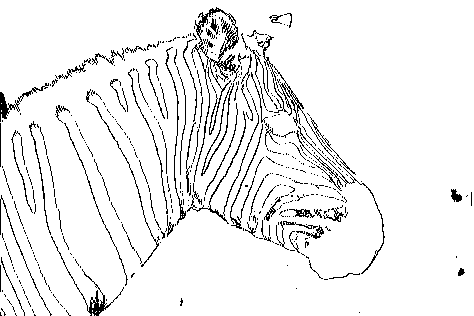

In [9]:
#test với ảnh mẫu
maTranAnh = img.open('images/input7.png').convert('RGB')
#maTranAnh = img.open('images/input2.gif').convert('RGB')
#maTranAnh = img.open('images/input4.jpg').convert('RGB')
#maTranAnh = img.open('images/input5.png').convert('RGB')
#maTranAnh = img.open('images/input6.jpg').convert('RGB')
m,n = maTranAnh.size
u = np.array(maTranAnh)[:,:,0]
print(u.shape)
u = u/255.0*2.0-1.0
ptvp.set_initial_value(u.flatten(), 0.0)
A1 = taoMaTranDoiXungPerceptron(cnn.quanThe[:5])
A2 = []
for j in range(1,10):
    A2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j:5*j+5]))
B1 = taoMaTranDoiXungPerceptron(cnn.quanThe[50:55])
B2 = []
for j in range(1,10):
    B2.append(taoMaTranDoiXungPerceptron(cnn.quanThe[5*j+50:5*j+55]))
I = cnn.quanThe[100]
uB1 = convolve2d(u, B1, 'same')
uB2 = tichChapBacHai(u, B2)
ptvp.set_f_params(uB1, uB2, A1, A2, n, m)
assert ptvp.successful()
x = (ptvp.integrate(cnn.t1))[:].reshape(n, m)
y = hamDauRa(x)
y = np.sign(y)
y = (y/2.0+0.5)*255
print(f'y = {y}')
out = img.fromarray(y).convert('RGB')
out.save('images/output5.png')
print('done')
maTranAnh.show()
out